In [1]:
from region_generator import random_walk, random_chunks, roll_top_left, create_puzzle
from plotting_fn import plot_visited_grid
import jax.random as jr
import jax.numpy as jnp
import jax

TypeError: got an unexpected keyword argument 'n_pieces'

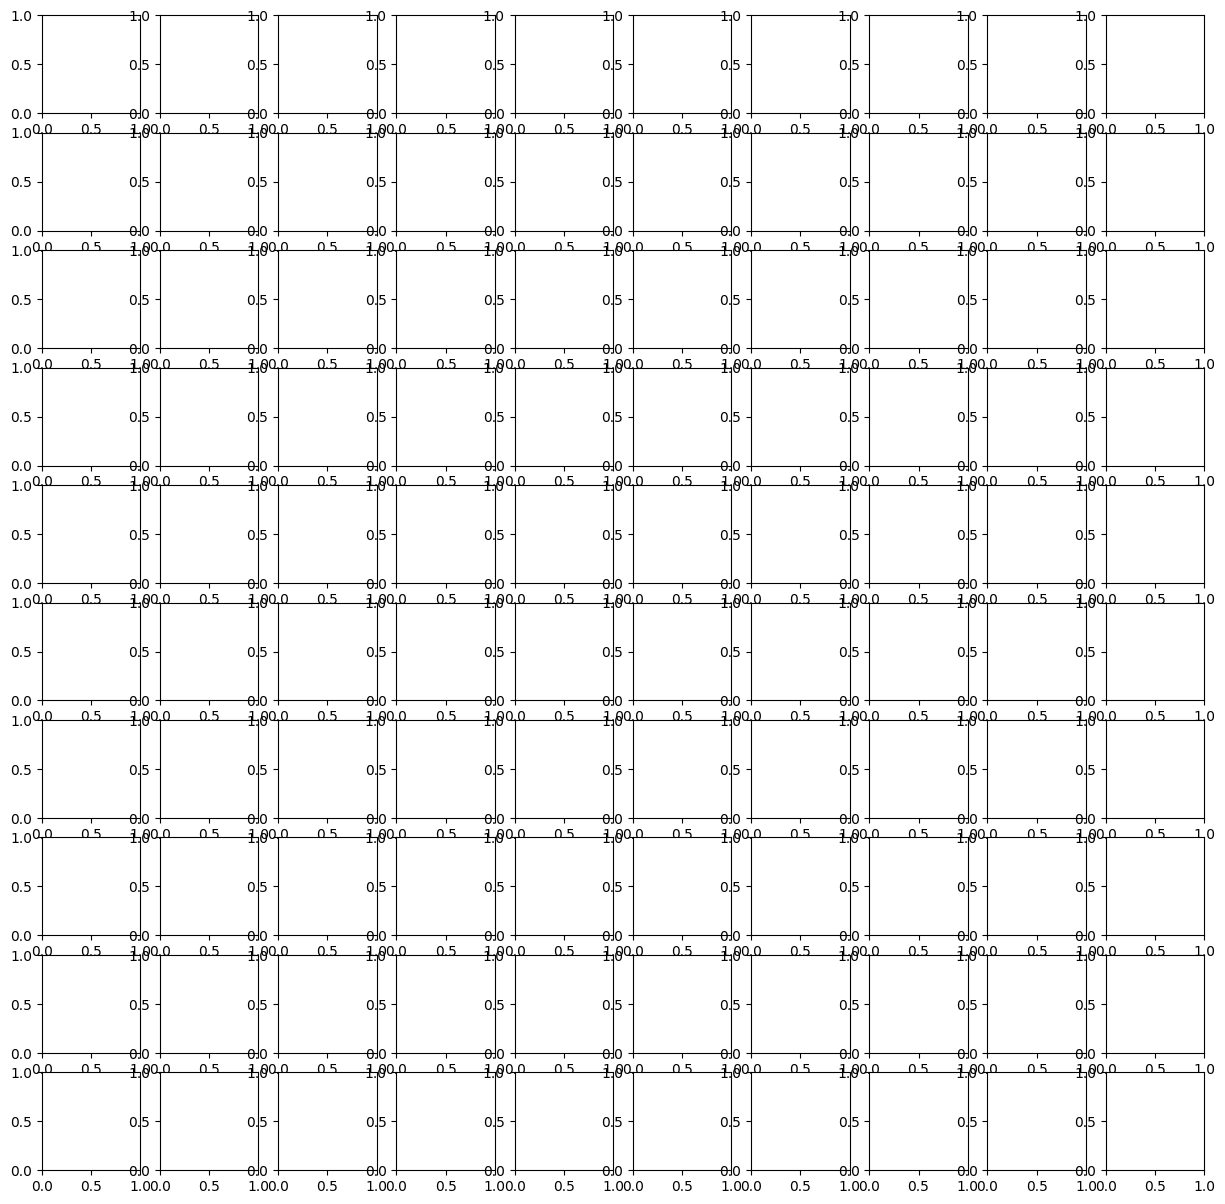

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    key = jr.key(i)
    full_path, chunks = random_walk(
        key=key,
        grid_size = 4,
        n_pieces = 4,
        min_piece_size = 2,
        max_piece_size = 5)
    plot_visited_grid(full_path, chunks, grid_size=4, ax=ax)



In [ ]:
full_path

In [ ]:
chunks

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
init_grid = jnp.zeros((4, 4), dtype=jnp.int32)


@eqx.filter_jit
def create_grid(full_path: jax.Array, grid_size: int, occupied_value: int = -1):
    init_grid = jnp.zeros((4, 4), dtype=jnp.int32)
    def scan_fn(carry, point):
        grid, stop = carry

        def update_fn(_):
            new_grid = grid.at[tuple(point)].set(-1)
            return (new_grid, False), None

        def skip_fn(_):
            return (grid, True), None

        # Check if point == (-1, -1)
        is_stop = jnp.all(point == -1)
        return jax.lax.cond(is_stop, skip_fn, update_fn, operand=None)

    carry_init = (init_grid, False)

    final_carry, _ = jax.lax.scan(scan_fn, carry_init, xs=full_path)

    final_grid, _ = final_carry
    return final_grid

# grid = create_grid(full_path, grid_size=4)


In [ ]:
grid = random_walk(jr.key(0), max_steps=3, grid_size=4)

create_grid(grid, grid_size=4, occupied_value=-1)

In [ ]:
jax.lax.dynamic_index_in_dim()

In [ ]:
plt.imshow(create_grid(full_path[9:9], grid_size=4), cmap='gray', origin='lower')
plt.colorbar()

In [ ]:
import jax
import jax.numpy as jnp

a = jnp.arange(20)  # example vector to slice
idx = jnp.array([3, 7, 9, 9, 9, 9, 9, 9, 9], dtype=jnp.int32)
pad_value = -1
target_length = 9

def slice_and_pad_fn(carry, idx_end):
    idx_start = carry
    length = idx_end - idx_start
    slice = jax.lax.dynamic_slice(a, (idx_start,), (jnp.minimum(length, a.shape[0] - idx_start),))

    # Pad to target_length
    padded = jnp.full((target_length,), pad_value)
    padded = padded.at[:slice.shape[0]].set(slice)

    return idx_end, padded

_, result = jax.lax.scan(slice_and_pad_fn, init=0, xs=idx)

print(result)


In [ ]:
full_path, chunks = random_walk(jr.key(1), max_steps=8, grid_size=4)

In [ ]:
chunks

In [ ]:
full_path.shape, chunks.shape

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
import equinox as eqx

@eqx.filter_jit
def random_chunk_encoding(key, n):
    def cond_fn(state):
        _, idx, _ = state
        return idx < n

    def body_fn(state):
        key, idx, out = state
        key, subkey = jax.random.split(key)

        # Randomly choose between 2 and 5
        chunk_size = jax.random.choice(subkey, jnp.array([2, 5]))

        # Clip chunk_size if it would go past `n`
        chunk_size = jnp.minimum(chunk_size, n - idx)

        # Get label = previous max + 1
        label = jnp.max(out) + 1

        # Create chunk filled with label
        update = jnp.full((chunk_size,), label, dtype=jnp.int32)

        # Dynamically insert into the output at position idx
        out = lax.dynamic_update_slice(out, update, (idx,))

        return (key, idx + chunk_size, out)

    # Initialize output
    out = jnp.zeros((n,), dtype=jnp.int32)
    init_state = (key, 0, out)

    _, _, final_out = lax.while_loop(cond_fn, body_fn, init_state)
    return final_out


In [ ]:
random_chunk_encoding(jr.key(0), 10)

In [ ]:
full_path

In [ ]:
jnp.ones()

In [ ]:
c = jnp.concatenate([jnp.array([0]), chunks.cumsum()])
c

In [ ]:
jax.lax.dynamice_slice

In [ ]:
import jax
import jax.numpy as jnp

def chunk_and_pad(full_path: jnp.ndarray, chunks: jnp.ndarray):
    # Compute start and length per chunk
    starts = jnp.concatenate([jnp.array([0]), chunks[:-1]])
    lengths = chunks - starts
    max_len = jnp.max(lengths)

    def get_chunk(i):
        start = starts[i]
        length = lengths[i]

        sl = jax.lax.dynamic_slice(full_path, (start, 0), (length, 2))
        pad_len = max_len - length
        padding = jnp.full((pad_len, 2), -1, dtype=full_path.dtype)
        return jnp.concatenate([sl, padding], axis=0)

    chunks_padded = jax.vmap(get_chunk)(jnp.arange(chunks.shape[0]))
    return chunks_padded

chunks_padded = chunk_and_pad(full_path, chunks)

In [ ]:
full_path

In [ ]:
def f(a, xs):
    return a, xs

jax.lax.scan(f,
             init=0,
             xs=(full_path, chunks))

In [ ]:
full_path

In [ ]:
@jax.jit
def extract_pieces(full_path, chunks, grid_size):
    def body_fn(carry, chunk):

        idx_start = carry
        idx_end = idx_start + chunk

        sl = jax.lax.dynamic_slice(full_path, (idx_start, 0), (idx_end - idx_start, 2))

        # Build the piece
        def paint_loop(i, grid):
            x, y = sl[i]
            return grid.at[x, y].set(1)

        grid = jnp.zeros((grid_size, grid_size), dtype=jnp.int32)
        grid = jax.lax.fori_loop(0, sl.shape[0], paint_loop, grid)

        # Shift to top-left
        shifted = roll_top_left(grid)

        return idx_end, shifted

    _, pieces = jax.lax.scan(
        body_fn,
        init=0,
        xs=chunks)
    return pieces


extract_pieces(full_path, chunks, grid_size=4)

In [ ]:
t
        shifted = roll_top_left(grid)

        return idx_end, shifted

    _, pieces = jax.lax.scan(body_fn, init=0, xs=jnp.arange(num_pieces))
    return pieces

pieces = extract_pieces(full_path, chunks, grid_size=4)

In [ ]:
full_path.shape, chunks.shape

In [ ]:
full_path

In [ ]:
chunks

In [ ]:
grid_size = 4
start_matrix = jnp.zeros((grid_size, grid_size))

idx_start = 0
for i, idx_end in enumerate(chunks, 1):
    if idx_end == idx_start:
        break
    sl = full_path[idx_start:idx_end]
    idx_start = idx_end
    for x, y in sl:
        start_matrix = start_matrix.at[x, y].set(-1)


In [ ]:
import jax.numpy as jnp

def roll_top_left(arr):
    # Roll up until first row is not all zeros
    def cond_row(x): return jnp.all(x[0] == 0)
    def body_row(x): return jnp.roll(x, shift=-1, axis=0)

    arr = jax.lax.while_loop(cond_row, body_row, arr)

    # Roll left until first column is not all zeros
    def cond_col(x): return jnp.all(x[:, 0] == 0)
    def body_col(x): return jnp.roll(x, shift=-1, axis=1)

    arr = jax.lax.while_loop(cond_col, body_col, arr)

    return arr


idx_start = 0
piece_list = []
for i, idx_end in enumerate(chunks, 1):
    starting_grid = jnp.zeros((grid_size, grid_size))
    if idx_end != idx_start:
        sl = full_path[idx_start:idx_end]
        for x, y in sl:
            starting_grid = starting_grid.at[x, y].set(1)
        
        starting_grid = roll_top_left(starting_grid)
    piece_list.append(starting_grid)
    idx_start = idx_end

In [ ]:
piece_list

In [ ]:
piece_list[0]

In [ ]:
import jax.numpy as jnp

def roll_top_left(arr):
    # Roll up until first row is not all zeros
    def cond_row(x): return jnp.all(x[0] == 0)
    def body_row(x): return jnp.roll(x, shift=-1, axis=0)

    arr = jax.lax.while_loop(cond_row, body_row, arr)

    # Roll left until first column is not all zeros
    def cond_col(x): return jnp.all(x[:, 0] == 0)
    def body_col(x): return jnp.roll(x, shift=-1, axis=1)

    arr = jax.lax.while_loop(cond_col, body_col, arr)

    return arr


In [ ]:
roll_top_left(piece_list[0])

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (piece, ax) in enumerate(zip(piece_list, axes.flat)):
   ax.imshow(piece, cmap='gray', vmin=0, vmax=1) 

In [ ]:
start_matrix

In [ ]:
jnp.arange(10)[0:3]

In [ ]:
jnp.arange(10)[3:5]

In [ ]:
start_matrix.T

In [ ]:
full_path[18]

In [ ]:
chunks

In [ ]:
o = jax.jit(jnp.sum)(full_path != -1)
o

In [ ]:
full_path

In [ ]:
chunks = random_chunks(jr.key(0), o, 51)

In [ ]:
chunks.sum()

In [ ]:
chunks.cumsum()